<a href="https://colab.research.google.com/github/Panda2498/Data_visualization_usingpython/blob/master/MaskDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Authorization Code: 4/yAFpJZtDCWY6Wgn7W1vovoRwHcHFLX8lFWFqPV8BRELFpPq0ZQsvNxs

In [0]:
!rm -rf /content/MAFA-Crop

In [0]:
!cp -r /content/drive/My\ Drive/MAFA-Crop  /content/

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
DIR_IMG_TRAIN = '/content/drive/My Drive/MAFA-Crop/train/'
DIR_IMG_TEST = '/content/drive/My Drive/MAFA-Crop/test/'
DIR_TMP_DATA = '/content/drive/My Drive/Checkpoint/'
DIR_OUTPUT = '/content/drive/My Drive/MAFA-Crop/models/'

IMG_SHAPE = (150,150,3)

In [19]:
!pip install Pillow
!pip install scipy==1.2.0

     |████████████████████████████████| 26.6MB 114kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [0]:
# imports

import os
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from scipy.misc import imsave
import numpy as np
import time

%matplotlib inline

Image have shape: (91, 91, 3)


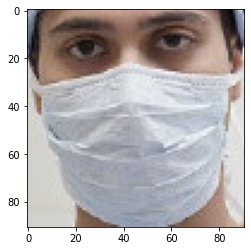

In [4]:
#EXPLORING THE DATA
sample_img_path = os.path.join(DIR_IMG_TRAIN,'M_1.jpg')
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

Image have shape: (250, 250, 3)


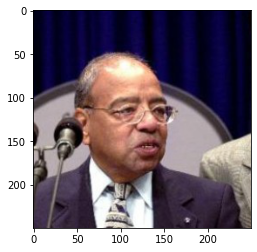

In [6]:
#EXPLORING THE DATA
sample_img_path = os.path.join(DIR_IMG_TRAIN,'N_5040.jpg')
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img)
print ('Image have shape: {}'.format(sample_img.shape))

In [0]:
#GET LABEL
from PIL import Image

def getLabel (X):
    """
    Return the label for an element based on the filename: 
        mask -> 1 
        non_mask -> 0
    """
    if ('M' in X):
        return 1
    else:
        return 0
    
def getLabels (X):
    """
    Returns an array that contains the label for each X
    """
    return np.array([getLabel(X[i]) for i in range(len(X))])

def getLabelFromScore (score):
    """
    Returns the label based on the probability
    if score >= 0.5, return 'mask'
    else return 'non_mask'
    """
    if (score >=0.5):
        return 'M'
    else:
        return 'N'

def normalizedArrayFromImageInPath (image_path, img_shape):
    """
    returns an the image in 'image' path normalized in an np array
    """
    img = loadAndResizeImage (image_path, img_shape[0], img_shape[1])
    return image.img_to_array(img) / 255.

def loadResizeNormalizeImages (basepath, path_array, img_shape):
    """
    Loads the images from the path 
    and returns them in an array
    """
    images = np.empty ((len(path_array), img_shape[0], img_shape[1], img_shape[2]), dtype=np.float32)
    for i in range (len(path_array)):
        images[i] = normalizedArrayFromImageInPath (os.path.join(basepath,path_array[i]), img_shape)
    return images

In [14]:
import os
import numpy as np

train_imgs = os.listdir(DIR_IMG_TRAIN)
train_imgs.sort()

#TRAIN VALID TEST: 70 10 20 => TOTAL ~ 5000

#Training data have 9000 img
train_x = np.concatenate([train_imgs[:1500],train_imgs[2000:3500],train_imgs[4500:6000],train_imgs[-4500:]],axis=0)
train_y = getLabels (train_x)

print ("Number of training examples = {}".format(len(train_x)))
print ("Number of training labels = {}".format(len(train_y)))

#Validation data have 1200 img 
validation_x = np.concatenate([train_imgs[1500:1700],train_imgs[3500:3700],train_imgs[4300:4500],train_imgs[-5100:-4500]],axis=0)
validation_y = getLabels (validation_x)

print ("Number of validation examples = {}".format (len(validation_x)))
print ("Number of validation labels = {}".format(len(validation_y)))

Number of training examples = 9000
Number of training labels = 9000
Number of validation examples = 1200
Number of validation labels = 1200


Using TensorFlow backend.


Mask #1 as image:


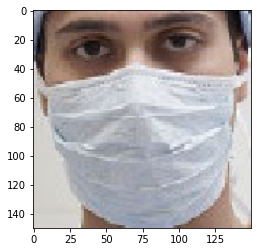

In [15]:
#PREPROCESSED DATA
# as long as images have different sizes, let's resize!

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
def loadAndResizeImage (img, w, h):
    '''
    loads the image in 'img' path and returns a PIL image of size (w,h)
    '''
    return image.load_img (img, target_size=(w,h))

# Mask example resized
mask_index = 1
sample_img_path = os.path.join(DIR_IMG_TRAIN,'M_'+str(mask_index)+'.jpg')
sample_img = loadAndResizeImage (sample_img_path, IMG_SHAPE[0], IMG_SHAPE[1])
plt.imshow(sample_img)
print ('Mask #'+str(mask_index)+' as image:')

In [16]:
#CHECKPOINT 
img_train_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, train_x, IMG_SHAPE)
np.save (os.path.join(DIR_TMP_DATA,'train_x'), img_train_x)
print (img_train_x.shape)
print ('Input X for training saved!')

img_validation_x = loadResizeNormalizeImages (DIR_IMG_TRAIN, validation_x, IMG_SHAPE)
np.save (os.path.join(DIR_TMP_DATA,'validation_x'), img_validation_x)
print (img_validation_x.shape)
print ('Input X for validation saved!')

print ('Checkpoint 1')

(9000, 150, 150, 3)
Input X for training saved!
(1200, 150, 150, 3)
Input X for validation saved!
Checkpoint 1


In [0]:
#Save in drive
!cp /content/drive/My\ Drive/Checkpoint/train_x.npy /content/drive/My\ Drive/Colab
!cp /content/drive/My\ Drive/Checkpoint/validation_x.npy /content/drive/My\ Drive/Colab

In [0]:
#PROPORTION
def MaskVsNon_MaskProportion (labels):
    N = 0
    M = 0
    for label in labels:
        if (label == 1):
            M = M + 1
        else:
            N = N + 1

    N_percent = (N/len(labels))*100.0
    M_percent = 100.0 - N_percent

    return M_percent, N_percent

In [19]:
import numpy as np
img_train_x = np.load (os.path.join(DIR_TMP_DATA,'train_x')+'.npy')
img_validation_x = np.load (os.path.join(DIR_TMP_DATA,'validation_x')+'.npy')

M, N = MaskVsNon_MaskProportion (train_y)
print ("--> Training set: Non Mask represent "+str(N)+"% of the total")
print ("    Mask represent "+str(M))

M, N = MaskVsNon_MaskProportion (validation_y)
print ("--> Validation set: Non Mask represent "+str(N)+"% of the total")
print ("    Mask represent "+str(M))

--> Training set: Non Mask represent 50.0% of the total
    Mask represent 50.0
--> Validation set: Non Mask represent 50.0% of the total
    Mask represent 50.0


In [20]:
#BUILDING THE MODEL
#Hide Warning tensorflow
#--------
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#---------
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
non_dense_predictions = Dense(1, activation='sigmoid')(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add dropout
x = Dropout (0.5)(x)
# one fully connected layer more
x = Dense(256, activation='relu')(x)
# add dropout
x = Dropout (0.3)(x)
# one fully connected layer more
x = Dense(32, activation='relu')(x)
# and a logistic layer --
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


87916544/87910968 [==============================] - 8s 0us/step


In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [22]:
model.fit (x=img_train_x, y=train_y, 
           batch_size=16, epochs=10, 
           validation_data=(img_validation_x, validation_y))

Train on 9000 samples, validate on 1200 samples
Epoch 1/10
9000/9000 [==============================] - 92s 10ms/step - loss: 0.3523 - acc: 0.9278 - val_loss: 6.7993 - val_acc: 0.5592
Epoch 2/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.1590 - acc: 0.9588 - val_loss: 0.0672 - val_acc: 0.9733
Epoch 3/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.0368 - acc: 0.9913 - val_loss: 0.0273 - val_acc: 0.9942
Epoch 4/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0136 - val_acc: 0.9958
Epoch 5/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.0123 - acc: 0.9971 - val_loss: 0.0136 - val_acc: 0.9958
Epoch 6/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.0115 - acc: 0.9969 - val_loss: 0.0161 - val_acc: 0.9975
Epoch 7/10
9000/9000 [==============================] - 67s 7ms/step - loss: 0.0102 - acc: 0.9972 - val_loss: 0.0410 - val_acc: 0.9858
Epoch 

In [27]:
#Save model
print ('Saving the model...')
model.save(os.path.join(DIR_OUTPUT,'model-10ep.h5'))
print ('Model saved! Filename: {}'.format (os.path.join(DIR_OUTPUT,'model-10ep.h5')))
print ('Checkpoint 2')

Saving the model...
Model saved! Filename: /content/drive/My Drive/MAFA-Crop/models/model-10ep.h5
Checkpoint 2


In [28]:
#Load model
from keras.models import load_model
#model = load_model(os.path.join(DIR_TMP_DATA,'model-10ep.h5'))
model = load_model('/content/drive/My Drive/MAFA-Crop/models/model-10ep.h5')
print ('Model loaded!')

Model loaded!


In [33]:
# Evaluation with test images the model didn't see before

#Test set original have 500 img

test_imgs = os.listdir(DIR_IMG_TEST)
test_imgs.sort
test_x = test_imgs[:1500]
test_y = getLabels (test_x)

print ("Number of test set images= "+str(len(test_x)))
print ("Number of test set labels = "+str(len(test_y)))

print ("First element of test set "+test_x[0])
print ("Label of first element of test set = "+str(test_y[0]))

Number of test set images= 1500
Number of test set labels = 1500
First element of test set M_668.jpg
Label of first element of test set = 1


In [34]:
print(test_x)

['M_668.jpg', 'N_480.jpg', 'M_712.jpg', 'M_196.jpg', 'M_137.jpg', 'M_156.jpg', 'N_148.jpg', 'M_690.jpg', 'M_30.jpg', 'M_199.jpg', 'N_203.jpg', 'N_623.jpg', 'N_495.jpg', 'N_38.jpg', 'N_435.jpg', 'M_265.jpg', 'M_713.jpg', 'M_218.jpg', 'M_497.jpg', 'N_565.jpg', 'M_71.jpg', 'M_260.jpg', 'N_111.jpg', 'M_146.jpg', 'M_328.jpg', 'N_40.jpg', 'N_598.jpg', 'M_379.jpg', 'N_615.jpg', 'N_508.jpg', 'M_50.jpg', 'M_310.jpg', 'N_142.jpg', 'N_200.jpg', 'N_539.jpg', 'M_413.jpg', 'M_210.jpg', 'M_140.jpg', 'N_334.jpg', 'N_102.jpg', 'M_490.jpg', 'N_563.jpg', 'N_746.jpg', 'N_8.jpg', 'N_653.jpg', 'N_743.jpg', 'N_384.jpg', 'M_313.jpg', 'N_547.jpg', 'N_722.jpg', 'M_126.jpg', 'M_108.jpg', 'N_432.jpg', 'N_227.jpg', 'N_607.jpg', 'M_347.jpg', 'M_258.jpg', 'M_510.jpg', 'N_534.jpg', 'N_243.jpg', 'N_720.jpg', 'N_141.jpg', 'N_233.jpg', 'M_332.jpg', 'N_53.jpg', 'N_101.jpg', 'M_48.jpg', 'M_702.jpg', 'M_652.jpg', 'N_1.jpg', 'M_177.jpg', 'M_632.jpg', 'N_24.jpg', 'M_489.jpg', 'N_124.jpg', 'N_285.jpg', 'N_146.jpg', 'M_699.jpg

In [35]:
img_test_x = loadResizeNormalizeImages (DIR_IMG_TEST, test_x, IMG_SHAPE)
print (img_test_x.shape)

(1500, 150, 150, 3)


In [36]:
print ('Saving test set...')
np.save (os.path.join(DIR_TMP_DATA,'test_x'), img_test_x)
print ('Input X for test saved!')
print ('Checkpoint 3')

Saving test set...
Input X for test saved!
Checkpoint 3


In [0]:
#Save in drive
!cp -r /content/drive/My\ Drive/Checkpoint /content/

In [0]:

#Save in drive
!cp -r /content/Checkpoint /content/drive/My\ Drive/

In [40]:
img_test_x = np.load (os.path.join(DIR_TMP_DATA,'test_x')+'.npy')
print ('Input X for evaluation loaded!')

# check the proportion organic vs recyclable
M, N = MaskVsNon_MaskProportion (test_y)

print ("--> Test set: Non Mask represent "+str(N)+"% of the total")
print ("    Mask represent "+str(M)+"%")

Input X for evaluation loaded!
--> Test set: Non Mask represent 50.0% of the total
    Mask represent 50.0%


In [41]:
preds = model.evaluate (x=img_test_x, y=test_y, batch_size=10)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


1500/1500 [==============================] - 9s 6ms/step

Loss = 0.005023081479909687
Test Accuracy = 0.9979999995231629


In [0]:
def predictFromPath (img_path, img_size=(150,150)):
    img = normalizedArrayFromImageInPath (img_path, img_size)
    return predictFromImg (img)

def predictFromImg (img):
    x = np.expand_dims(img, axis=0)
    return model.predict(x)[0][0]

In [43]:
%cd /content/MAFA-Crop/test
!ls

/content/MAFA-Crop/test
M_100.jpg  M_295.jpg  M_489.jpg  M_682.jpg  N_1.jpg    N_394.jpg  N_588.jpg
M_101.jpg  M_296.jpg  M_48.jpg	 M_683.jpg  N_200.jpg  N_395.jpg  N_589.jpg
M_102.jpg  M_297.jpg  M_490.jpg  M_684.jpg  N_201.jpg  N_396.jpg  N_58.jpg
M_103.jpg  M_298.jpg  M_491.jpg  M_685.jpg  N_202.jpg  N_397.jpg  N_590.jpg
M_104.jpg  M_299.jpg  M_492.jpg  M_686.jpg  N_203.jpg  N_398.jpg  N_591.jpg
M_105.jpg  M_29.jpg   M_493.jpg  M_687.jpg  N_204.jpg  N_399.jpg  N_592.jpg
M_106.jpg  M_2.jpg    M_494.jpg  M_688.jpg  N_205.jpg  N_39.jpg   N_593.jpg
M_107.jpg  M_300.jpg  M_495.jpg  M_689.jpg  N_206.jpg  N_3.jpg	  N_594.jpg
M_108.jpg  M_301.jpg  M_496.jpg  M_68.jpg   N_207.jpg  N_400.jpg  N_595.jpg
M_109.jpg  M_302.jpg  M_497.jpg  M_690.jpg  N_208.jpg  N_401.jpg  N_596.jpg
M_10.jpg   M_303.jpg  M_498.jpg  M_691.jpg  N_209.jpg  N_402.jpg  N_597.jpg
M_110.jpg  M_304.jpg  M_499.jpg  M_692.jpg  N_20.jpg   N_403.jpg  N_598.jpg
M_111.jpg  M_305.jpg  M_49.jpg	 M_693.jpg  N_210.jpg  N_404.jpg  N_

Prediction took 0.033 seconds
It's a N! (with a score of 1.5193110414202238e-07) 0 -> Non Mask / 1 -> Mask


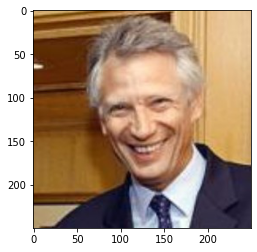

In [53]:
img_path = DIR_IMG_TEST+'N_273.jpg'
display_img = image.load_img(img_path)
start = time.time()
score = predictFromPath (img_path)
end = time.time()
print("Prediction took {:.3f} seconds".format (end - start))
print("It's a {}! (with a score of {}) 0 -> Non Mask / 1 -> Mask".format (getLabelFromScore (score), score))
plt.imshow(display_img)

In [0]:
import numpy as np
import cv2
img_path = DIR_IMG_TEST+'N_776.jpg'
display_img = image.load_img(img_path)
img = np.array(display_img)
img = cv2.resize(img,(150,150))
img = img/255.0
score = predictFromImg(img)
print(score)

0.12457632
